In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_model_optimization as tfmot
import tensorflow_probability as tfp
from tensorflow_model_optimization.sparsity import keras as sparsity
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score


# LeNet 300-100-10 MNIST dataset: _The Lottery Ticket Hypothesis_

The following code implements the _The Lottery Ticket Hypothesis_ for _LeNet-300-100-10_ with MNIST dataset. However, this code uses a __naive _unstructured layer-wise pruning___ strategy where the two hidden layers are pruned with 20% and the output layer is pruned at 10%.

The pruning follows removing the lowest 20% or 10% of the weights in the layers and attempts to see the result of such a simple weight magnitude based unstrucutred pruning on the performance of following the hypothesis

In [2]:
print("\nTensorFlow version: {0} & tensorflow_probability version: {1}\n".format(
    tf.__version__, tfp.__version__
))


TensorFlow version: 2.0.0 & tensorflow_probability version: 0.8.0-rc0



In [3]:
batch_size = 60
num_classes = 10
num_epochs = 50

In [4]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train = (60000, 10)
X_test.shape = (10000, 784), y_test = (10000, 10)


### Prepare MNIST dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

### Step - 1: Randomly initialize a Neural Network
Here, we choose the architecture for classification of MNIST dataset which is 300 100 densely conncected network and randomly initialize the weights/biases of the neural network, and also __save__ this random weights/biases initialization, which will be used later.

In [15]:
def LeNet_NN():
    """
    Define LeNet 300-100-10 Dense Fully Connected
    Neural Network for MNIST multi-class classification
    """
    
    model = Sequential()
    
    model.add(
        Dense(units = 300, activation = 'relu',
              kernel_initializer = tf.initializers.GlorotNormal(),
              input_shape = (784,)
             )
    )
    
    model.add(
        Dense(units = 100, activation = 'relu',
              kernel_initializer = tf.initializers.GlorotNormal()
             )
    )
    
    model.add(
        Dense(units = 10, activation = 'softmax'
             )
    )
    
    # Compile pruned CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.001),
        metrics=['accuracy'])
    
    return model

    

In [16]:
# Initialize an instance of NN-
orig_model = LeNet_NN()

In [17]:
# Save random weights-
orig_model.save_weights("Random_Weights_LeNet.h5", overwrite=True)

In [18]:
# Save random weights-
orig_model.save_weights("Winning_Ticket_Weights_LeNet.h5", overwrite=True)

In [19]:
print("\nLayer-wise parameters in LeNet Neural Network:\n")

for layer in orig_model.trainable_weights:
    print(layer.shape)


Layer-wise parameters in LeNet Neural Network:

(784, 300)
(300,)
(300, 100)
(100,)
(100, 10)
(10,)


In [20]:
# Count number of non-zero parameters in trained neural network-

print("\nIn original unpruned model, number of nonzero parameters in each layer are: \n")

orig_sum_params = 0

for layer in orig_model.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    orig_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(orig_sum_params))



In original unpruned model, number of nonzero parameters in each layer are: 

235200
0
30000
0
1000
0

Total number of trainable parameters = 266200



In [21]:
# Get model summary-
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Create a mask:

A mask is created where all parameters equal to one.

This will be used later by GradientTape for training the defined neural network.


In [22]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = LeNet_NN()

In [23]:
# Assign all masks to one-

for wts in mask_model.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )


In [24]:
print("\nMask model metrics:")
print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of ones in mask = {0}\n".format(masked_sum_params))




Mask model metrics:
layer-wise manner model, number of nonzero parameters in each layer are: 

235200
300
30000
100
1000
10

Total number of ones in mask = 266610



In [25]:
# Define number of pruning rounds-
num_pruning_rounds = 4

### Python 3 dictionary to hold model training metrics for each of n rounds:

In [26]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

for x in range(num_pruning_rounds + 1):
    history = {}
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)

    history_main[x + 1] = history


In [27]:
# Sanity check-
history_main[1]['loss'].shape

(50,)

In [28]:
history_main.keys()

dict_keys([1, 2, 3, 4, 5])

## Layer-wise pruning:

In the paper, it's mentioned that you remove a percentage of the lowest magnitudes weights within a layer, as this is an _unstructured pruning_ in order for the winning ticket to be sparse.

Also, the _connections to outputs are pruned at half of the rate as compared to the rest of the network_

### __NOTE:__

Remeber, for _LeNet-300-100-10_ neural network, the pruning for the last layer or output layer happens at half the pruning rate as compared to the rest of the network

In [29]:
def prune_layers(model, layer_pruning_percentage):
    '''
    Function to perform unstructured layer-wise
    pruning
    Last layer is pruned at half the pruning rate
    as compared to the rest of the network
    '''
    
    j = 0

    while j < len(model.trainable_weights):
        
        if j == 4:
            pk_half = tfp.stats.percentile(model.trainable_weights[j], q = layer_pruning_percentage / 2)
            # print("Layer = {0}, pk_half = {1:.4f}\n".format(j + 1, pk_half.numpy()))
            
            # tf.where(x <= p30, 0, x)
            model.trainable_weights[j].assign(tf.where(model.trainable_weights[j] <= pk_half, 0., model.trainable_weights[j]))
            '''
            model.trainable_weights[j].assign(tf.where(tf.less_equal(
                model.trainable_weights[j], pk_half), 0., model.trainable_weights[j]))
            '''
        else:
            pk = tfp.stats.percentile(model.trainable_weights[j], q = layer_pruning_percentage)
            # print("Layer = {0}, pk = {1:.4f}\n".format(j + 1, pk.numpy()))
        
            model.trainable_weights[j].assign(tf.where(model.trainable_weights[j] <= pk, 0., model.trainable_weights[j]))
            '''
            model.trainable_weights[j].assign(tf.where(tf.less_equal(
                model.trainable_weights[j], pk), 0., model.trainable_weights[j]))
            '''

        # We are not pruning biases, hence we increment by two-
        j += 2
    
    return model


In [30]:
# Percentage of weights to remove-
layer_percentage = 20.0

In [31]:
orig_sum_params = 266610

In [32]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [33]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    model_gt = LeNet_NN()
    
    # Load winning ticket (from above-)
    model_gt.load_weights("Winning_Ticket_Weights_LeNet.h5")
        
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        for x, y in train_dataset:
            train_one_step(model_gt, mask_model, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(x_t, y_t)
            test_step(model_gt, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
     
    
    # Save trained model weights-
    model_gt.save_weights("Trained_Weights_LeNet.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
        
    # Instantiate a Neural Network model to be pruned-
    pruned_model = LeNet_NN()
    
    # Load weights from trained and unpruned model-
    pruned_model.load_weights("Trained_Weights_LeNet.h5")
    
    # Call method to prune weights using 'layer_percentage' parameter-
    pruned_model = prune_layers(pruned_model, layer_percentage)
    
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    # Sanity-check: confirm that p = 30% of the weights are actually pruned away from the network-
    print("\nRound = {0}, % of weights pruned away = {1:.2f}%\n".format( \
                                                i, (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))
    
    # Save weights of PRUNED and Trained model BEFORE stripping-
    pruned_model.save_weights("Pruned_Weights_LeNet.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    mask_model = LeNet_NN()
    
    # Load weights of PRUNED model-
    mask_model.load_weights("Pruned_Weights_LeNet.h5")
        
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    for wts in mask_model.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    
    
    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    winning_ticket_model = LeNet_NN()
    
    # Load weights of PRUNED model-
    winning_ticket_model.load_weights("Pruned_Weights_LeNet.h5")
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model.trainable_weights,
                                    winning_ticket_model.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0.), 0., orig_wts))
    
    
    # Save the weights (with pruning parameters) extracted to a file-
    winning_ticket_model.save_weights("Winning_Ticket_Weights_LeNet.h5", overwrite=True)





Iterative pruning round: 1


Epoch 1, Loss: 0.2235, Accuracy: 93.5133, Test Loss: 0.1118, Test Accuracy: 96.389999
Total number of trainable parameters = 266610

Epoch 2, Loss: 0.0877, Accuracy: 97.3267, Test Loss: 0.0947, Test Accuracy: 97.000000
Total number of trainable parameters = 266610

Epoch 3, Loss: 0.0578, Accuracy: 98.2033, Test Loss: 0.0713, Test Accuracy: 97.869995
Total number of trainable parameters = 266610

Epoch 4, Loss: 0.0428, Accuracy: 98.5883, Test Loss: 0.0770, Test Accuracy: 97.689995
Total number of trainable parameters = 266610

Epoch 5, Loss: 0.0325, Accuracy: 98.9150, Test Loss: 0.0729, Test Accuracy: 97.939995
Total number of trainable parameters = 266610

Epoch 6, Loss: 0.0265, Accuracy: 99.1000, Test Loss: 0.0776, Test Accuracy: 97.759995
Total number of trainable parameters = 266610


'EarlyStopping' called!


Round = 1, total number of trainable parameters = 213467


Round = 1, % of weights pruned away = 19.93%




Iterative pruning round: 2


Epoch 

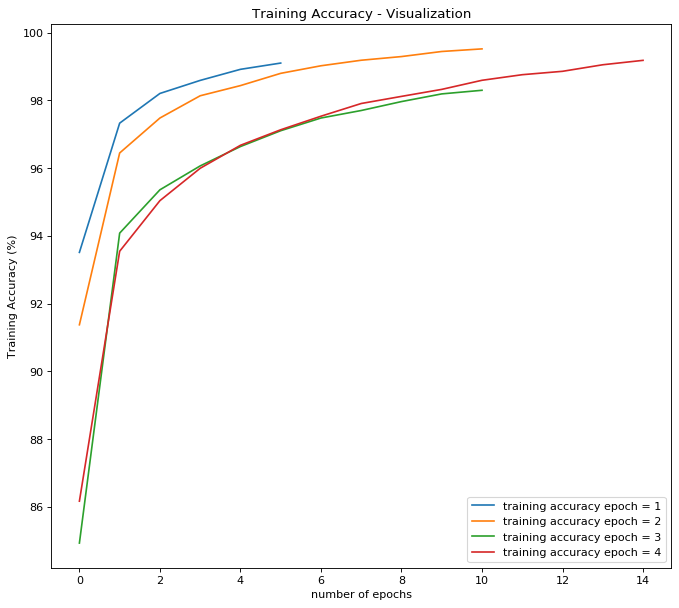

In [34]:
# Plot the different epoch's training accuracy:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in range(1, 5):
    plt.plot(history_main[epoch]['accuracy'], label = "training accuracy epoch = {0}".format(epoch))

plt.title("Training Accuracy - Visualization")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Training Accuracy (%)")
plt.show()


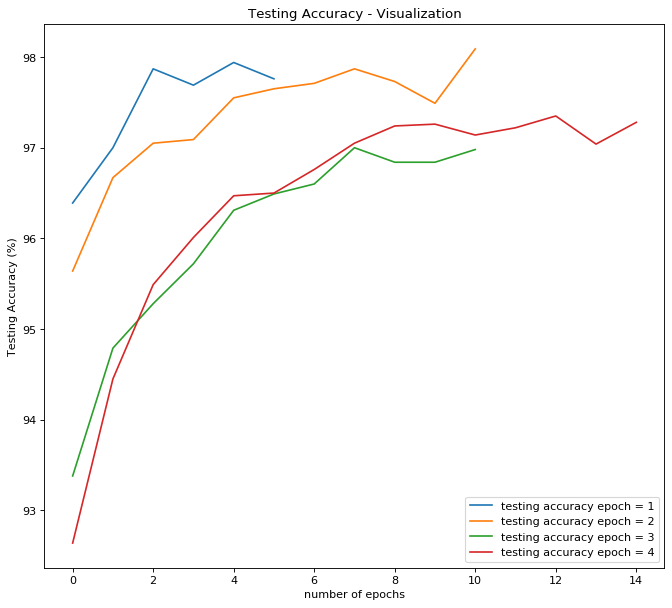

In [35]:
# Plot the different epoch's testing accuracy:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in range(1, 5):
    plt.plot(history_main[epoch]['val_accuracy'], label = "testing accuracy epoch = {0}".format(epoch))

plt.title("Testing Accuracy - Visualization")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Testing Accuracy (%)")
plt.show()


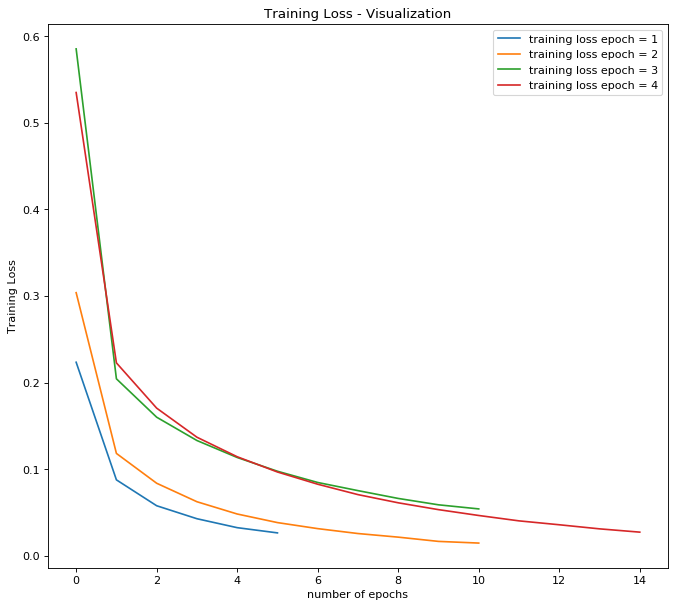

In [36]:
# Plot the different epoch's training loss:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in range(1, 5):
    plt.plot(history_main[epoch]['loss'], label = "training loss epoch = {0}".format(epoch))

plt.title("Training Loss - Visualization")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Training Loss")
plt.show()



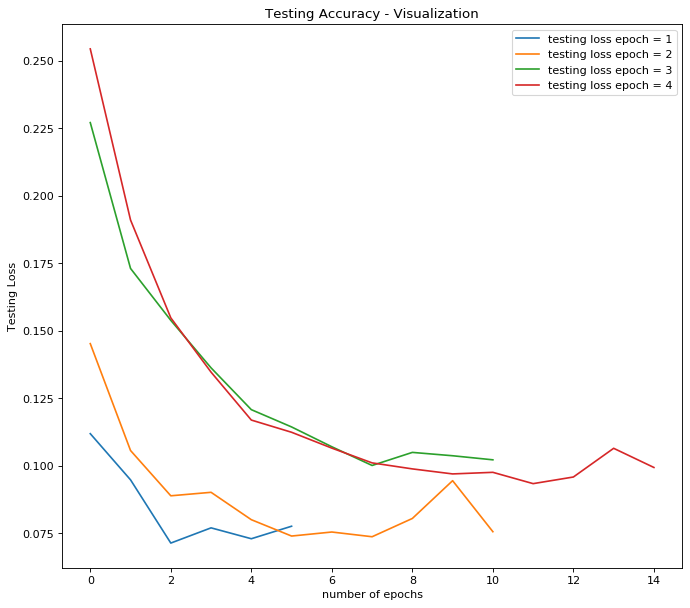

In [37]:
# Plot the different epoch's testing loss:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for epoch in range(1, 5):
    plt.plot(history_main[epoch]['val_loss'], label = "testing loss epoch = {0}".format(epoch))

plt.title("Testing Accuracy - Visualization")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("Testing Loss")
plt.show()

### Observation:

We can see that as if we prune more and more of the network, the model:

1. needs more number of epochs for Early Stopping to occur (for model to converge)

1. testing accuracy goes down

Therefore, this naive _unstructured weight based pruning_ does __not__ work!

### Save Python 3.X dictionary as pickled object so that it can be used later:

In [39]:
import pickle
import os

In [40]:
os.getcwd()

'/home/arjun/Desktop/Codes/Lottery_Hypothesis-Resources/Latest_Works'

In [41]:
# Save 'history_main' Python 3 dictionary-
with open("/home/arjun/Desktop/Codes/Lottery_Hypothesis-Resources/Latest_Works/LTH-LeNet_300_100_10-history_main.pkl", "wb") as f:
    pickle.dump(history_main, f)

In [42]:
# Load saved Python 3 dictionary-
with open("/home/arjun/Desktop/Codes/Lottery_Hypothesis-Resources/Latest_Works/LTH-LeNet_300_100_10-history_main.pkl", "rb") as f:
    history_main_loaded = pickle.load(f)

In [43]:
# Sanity check-
history_main_loaded.keys()

dict_keys([1, 2, 3, 4, 5])

In [44]:
history_main_loaded[1]

{'accuracy': array([93.51333618, 97.32666779, 98.20333099, 98.58833313, 98.91500092,
        99.09999847]),
 'val_accuracy': array([96.38999939, 97.        , 97.86999512, 97.68999481, 97.93999481,
        97.75999451]),
 'loss': array([0.22345984, 0.08770046, 0.05781899, 0.04283521, 0.03251928,
        0.02648287]),
 'val_loss': array([0.11183644, 0.09474027, 0.07133102, 0.07696308, 0.07293585,
        0.07756598])}